In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def calculate_mse(e):
    """Calculate the Mean Squared Error (MSE) for vector e."""
    return 1/2 * np.mean(e**2)

def calculate_mae(e):
    """Calculate the Mean Absolute Error (MAE) for vector e."""
    return np.mean(np.abs(e))

def compute_loss(y, tx, w, loss_type='mse'):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.
        loss_type: 'mse' or 'mae' to specify which loss to calculate.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # Calculate the error
    e = y - tx.dot(w)

    # Return MSE or MAE based on the selected loss type
    if loss_type == 'mse':
        return calculate_mse(e)
    elif loss_type == 'mae':
        return calculate_mae(e)
    else:
        raise ValueError("Invalid loss_type. Choose 'mse' or 'mae'.")


# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    # Initialize a matrix to store the losses for each combination of w0 and w1
    losses = np.zeros((len(grid_w0), len(grid_w1)))
    
    # Iterate over all combinations of w0 and w1
    for ind_row, w0 in enumerate(grid_w0):
        for ind_col, w1 in enumerate(grid_w1):
            # Form the weight vector w = [w0, w1]
            w = np.array([w0, w1])
            
            # Compute the loss for this combination of weights
            loss = compute_loss(y, tx, w)
            
            # Store the computed loss in the losses matrix
            losses[ind_row, ind_col] = loss
            
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.071 seconds


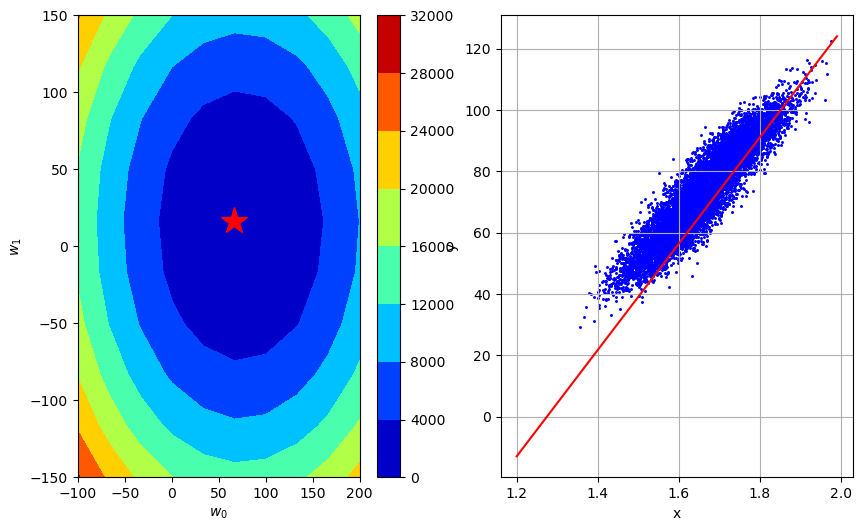

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ), containing the gradient of the loss at w.
    """
    # Compute the error (residuals)
    err = y - tx.dot(w)
    
    # Compute the gradient
    grad = -tx.T.dot(err) / len(err)
    
    return grad

Please fill in the functions `gradient_descent` below:

In [9]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # Compute the gradient and the loss
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)

        # Update w by taking a step in the direction of the negative gradient
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [10]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147362, w1=9.435798704492294
GD iter. 1/49: loss=265.3024621089602, w0=66.69746902191571, w1=12.266538315840004
GD iter. 2/49: loss=37.87837955044127, w0=71.31498610804834, w1=13.115760199244331
GD iter. 3/49: loss=17.41021212017447, w0=72.70024123388814, w1=13.370526764265632
GD iter. 4/49: loss=15.568077051450455, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412119, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543453, w0=73.29388305071, w1=13.479705271317192
GD 

In [11]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [12]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # Compute the error for the mini-batch
    err = y - tx.dot(w)
    
    # Compute the stochastic gradient
    stoch_grad = -tx.T.dot(err) / len(err)
    
    return stoch_grad



def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # Create a random mini-batch of data
        for mini_y, mini_tx in batch_iter(y, tx, batch_size):
            # Compute the stochastic gradient for the mini-batch
            stoch_grad = compute_stoch_gradient(mini_y, mini_tx, w)
            
            # Update w using the stochastic gradient
            w = w - gamma * stoch_grad
            
            # Compute the loss for this mini-batch
            loss = compute_loss(y, tx, w)
            
            # Store updated weights and loss
            ws.append(w)
            losses.append(loss)
            print(
                "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )

    return losses, ws

In [18]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2246.0904928054647, w0=7.466272606321732, w1=2.1602696528074983
SGD iter. 1/49: loss=2055.4650498354204, w0=13.008874066808815, w1=-7.635952825006994
SGD iter. 2/49: loss=1711.643474710837, w0=18.743763828114062, w1=-6.935855567801538
SGD iter. 3/49: loss=1433.0042318668268, w0=23.60375620172444, w1=-5.654657445586283
SGD iter. 4/49: loss=951.8277056110661, w0=31.182161194111444, w1=3.5055840452601394
SGD iter. 5/49: loss=732.4881614522252, w0=36.63346029726827, w1=3.9815497308141925
SGD iter. 6/49: loss=610.1309926198907, w0=40.65035403601637, w1=2.349228171244593
SGD iter. 7/49: loss=549.3391896206826, w0=43.07246304455542, w1=1.047093162251625
SGD iter. 8/49: loss=403.0737625967145, w0=47.3580268833281, w1=3.3453602680488475
SGD iter. 9/49: loss=389.8785896163004, w0=48.20851433202308, w1=2.5386098616316395
SGD iter. 10/49: loss=281.59458528321943, w0=51.4268535200903, w1=6.1143400186307675
SGD iter. 11/49: loss=256.42871382969884, w0=53.890042105057496, w1=3.20

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [31]:
import datetime
from helpers import *

# Reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=False)  # Subsample data without outliers

height_with_outliers, weight_with_outliers, gender_with_outliers = load_data(sub_sample=True, add_outlier=True)  # Subsample data with outliers

# Standardize the features and build the model data
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

x_outliers, mean_x_outliers, std_x_outliers = standardize(height_with_outliers)
y_outliers, tx_outliers = build_model_data(x_outliers, weight_with_outliers)

In [32]:
y.shape, tx.shape

((200,), (200, 2))

In [33]:
from plots import gradient_descent_visualization

# Define parameters for gradient descent
max_iters = 50
gamma = 0.7

# Initialize weights
w_initial = np.array([0, 0])

# Fit the model on subsampled data (without outliers)
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()
print(f"GD without outliers: execution time={execution_time:.3f} seconds")

# Fit the model on subsampled data with outliers
start_time = datetime.datetime.now()
gd_losses_outliers, gd_ws_outliers = gradient_descent(y_outliers, tx_outliers, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()
execution_time_outliers = (end_time - start_time).total_seconds()
print(f"GD with outliers: execution time={execution_time_outliers:.3f} seconds")

GD iter. 0/49: loss=2829.2722244384163, w0=51.54259072181176, w1=10.132993413506084
GD iter. 1/49: loss=267.0500258779429, w0=67.0053679383553, w1=13.172891437557825
GD iter. 2/49: loss=36.45002800750046, w0=71.64420110331838, w1=14.084860844773322
GD iter. 3/49: loss=15.696028199160635, w0=73.03585105280729, w1=14.358451666937965
GD iter. 4/49: loss=13.828168216410077, w0=73.45334603765397, w1=14.440528913587356
GD iter. 5/49: loss=13.660060817962522, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=13.644931152102242, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=13.643569482174817, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=13.643446931881353, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=13.643435902354941, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=13.64343490969756, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=13.643434820358397, w0=73.6322333285226, w1=14.4756971834540

In [34]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [35]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # Compute the error
    e = y - tx.dot(w)
    
    # Compute the subgradient
    subgrad = -tx.T.dot(np.sign(e)) / len(y)
    
    return subgrad

In [36]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # Compute the subgradient and the MAE loss
        subgrad = compute_subgradient_mae(y, tx, w)
        loss = compute_loss(y, tx, w, loss_type='mae')
        
        # Update w using the subgradient
        w = w - gamma * subgrad
        
        # Store the updated weights and loss
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [37]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=73.63227245973114, w0=0.7, w1=1.689537398874563e-15
SubGD iter. 1/499: loss=72.93227245973114, w0=1.4, w1=3.379074797749126e-15
SubGD iter. 2/499: loss=72.23227245973115, w0=2.0999999999999996, w1=5.068612196623689e-15
SubGD iter. 3/499: loss=71.53227245973116, w0=2.8, w1=6.758149595498252e-15
SubGD iter. 4/499: loss=70.83227245973114, w0=3.5, w1=8.447686994372815e-15
SubGD iter. 5/499: loss=70.13227245973114, w0=4.2, w1=1.0137224393247379e-14
SubGD iter. 6/499: loss=69.43227245973115, w0=4.9, w1=1.1826761792121942e-14
SubGD iter. 7/499: loss=68.73227245973115, w0=5.6000000000000005, w1=1.3516299190996506e-14
SubGD iter. 8/499: loss=68.03227245973115, w0=6.300000000000001, w1=1.5205836589871068e-14
SubGD iter. 9/499: loss=67.33227245973114, w0=7.000000000000001, w1=1.689537398874563e-14
SubGD iter. 10/499: loss=66.63227245973115, w0=7.700000000000001, w1=1.8584911387620192e-14
SubGD iter. 11/499: loss=65.93227245973114, w0=8.4, w1=2.0274448786494754e-14
SubGD it

In [38]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))